<a href="https://colab.research.google.com/github/kittikhun62/efficientnet_keras_transfer_learning/blob/master/2Class_3000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import from drive

In [1]:
import pandas as pd
import shutil
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
     

## hyper parameter


In [3]:
batch_size = 16

width = 150
height = 150

epochs = 1000 #จำนวนรอบในการ Train

NUM_TRAIN = 598  # จำนวนภาพ Train
NUM_TEST = 101 #จำนวนภาพ Test

dropout_rate = 0.3
input_shape = (height, width, 3) #ขนาด image enter

## Clone efficientnet repo

In [4]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 779, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 779 (delta 219), reused 248 (delta 187), pack-reused 478
Receiving objects: 100% (779/779), 13.20 MiB | 30.93 MiB/s, done.
Resolving deltas: 100% (459/459), done.
/content/efficientnet_keras_transfer_learning


## Import efficientnet and load the conv base model

In [5]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [6]:
base_dir = '/content/drive/My Drive/new project'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

## load model

In [7]:

import sys
sys.path.append('/content/drive/My Drive/new/2Class_2000.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [8]:
#load model 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/new/2Class_2000.h5')
height = width = model.input_shape[1]

In [9]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


## Setting data augmentation

In [10]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
#Image Augmentation 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, # image input 0-255 --> 0-1 เปลี่ยนค่าสี
      rotation_range=40,# หมุนภาพในองศา
      width_shift_range=0.2, #เปลี่ยนความกว้าง
      height_shift_range=0.2, #ปลี่ยนความสูง
      shear_range=0.2, #ทำให้ภาพเบี้ยว
      zoom_range=0.2, # Randomly zoom image
      horizontal_flip=True, 
      #โดย Default เมื่อมีการเลื่อนภาพ บิดภาพ หมุนภาพ จะเกิดพื้นที่ว่างที่มุม 
      #ซึ่งจะมีการเติมภาพให้เต็มโดยใช้เทคนิคแบบ Nearest neighbor ซึ่งเป็นการดึงสีบริเวณใหล้าเคียงมาระบายให้เต็ม แต่เราก็ยังสามารถกำหนดวิธีการ Fill ภาพด้วยเทคนิคอื่นได้จาก Parameter fill_mode
      fill_mode='nearest')
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 598 images belonging to 2 classes.
Found 101 images belonging to 2 classes.


In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-11-caa7b37242a8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/1000
37/37 [==============================] - 42s 848ms/step - loss: 0.4976 - acc: 0.7302 - val_loss: 0.6739 - val_acc: 0.6458
Epoch 2/1000
37/37 [==============================] - 3s 63ms/step - loss: 0.5312 - acc: 0.7251 - val_loss: 0.6839 - val_acc: 0.6354
Epoch 3/1000
37/37 [==============================] - 3s 64ms/step - loss: 0.5321 - acc: 0.7423 - val_loss: 0.6691 - val_acc: 0.6458
Epoch 4/1000
37/37 [==============================] - 3s 65ms/step - loss: 0.5180 - acc: 0.7474 - val_loss: 0.6472 - val_acc: 0.6562
Epoch 5/1000
37/37 [==============================] - 3s 65ms/step - loss: 0.5605 - acc: 0.7027 - val_loss: 0.6576 - val_acc: 0.6354
Epoch 6/1000
37/37 [==============================] - 3s 63ms/step - loss: 0.5226 - acc: 0.7302 - val_loss: 0.6505 - val_acc: 0.6458
Epoch 7/1000
37/37 [==============================] - 3s 64ms/step - loss: 0.5316 - acc: 0.7440 - val_loss: 0.6499 - val_acc: 0.6458
Epoch 8/1000
37/37 [==============================] - 3s 65ms/step 

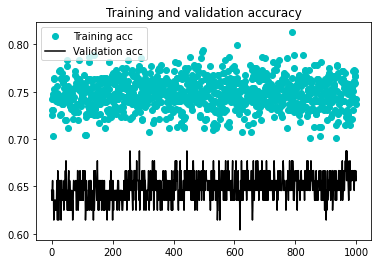

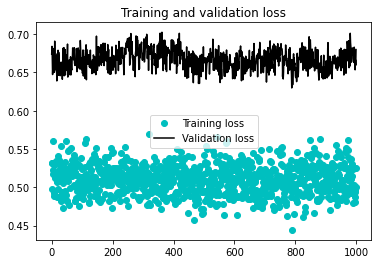

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'co', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'co', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
os.makedirs('./content/drive/My Drive/new', exist_ok=True)
model.save('./content/drive/My Drive/new/2Class_3000.h5')

In [14]:
from google.colab import files
files.download("./content/drive/My Drive/new/2Class_3000.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>